In [29]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_graphviz
from time import clock
import warnings
warnings.simplefilter('ignore')

In [2]:
# Import data
class_data = pd.read_csv("winequality-red.csv", delimiter=";")
X, y = class_data.iloc[:,:-1], class_data.iloc[:,-1]-3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(class_data)
print(class_data.describe())

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
5               7.4             0.660         0.00             1.8      0.075   
6               7.9             0.600         0.06             1.6      0.069   
7               7.3             0.650         0.00             1.2      0.065   
8               7.8             0.580         0.02             2.0      0.073   
9               7.5             0.500         0.36             6.1      0.071   
10              6.7             0.580         0.08             1.8      0.097   
11              7.5         

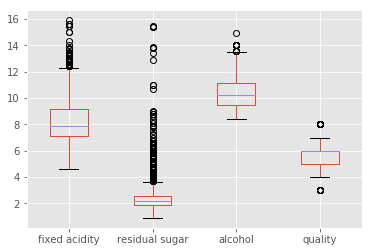

In [3]:
plt.style.use('ggplot')
class_data.boxplot(['fixed acidity','residual sugar','alcohol','quality'])

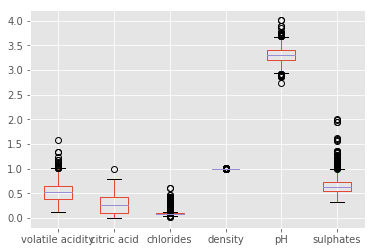

In [4]:
class_data.boxplot(['volatile acidity','citric acid','chlorides','density','pH','sulphates'])

quality
3    [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
4    [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
5    [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
6    [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
7    [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
8    [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
dtype: object

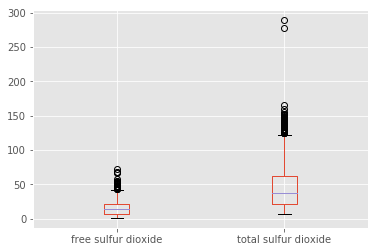

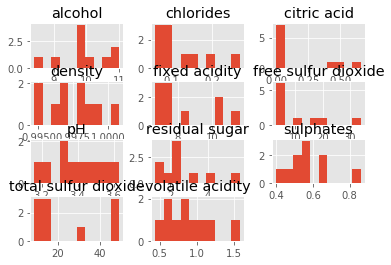

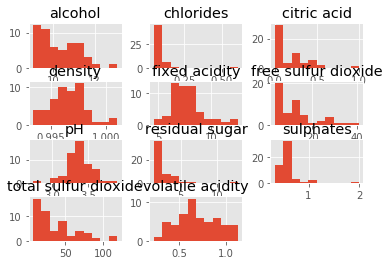

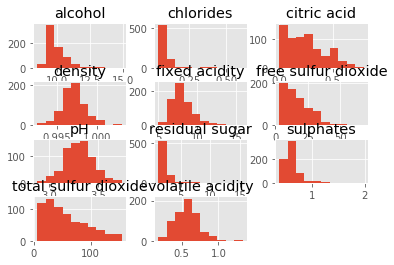

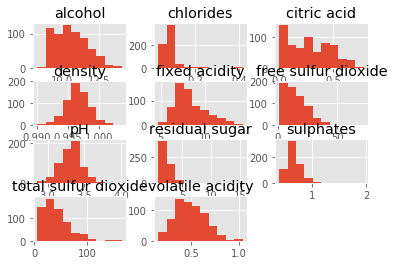

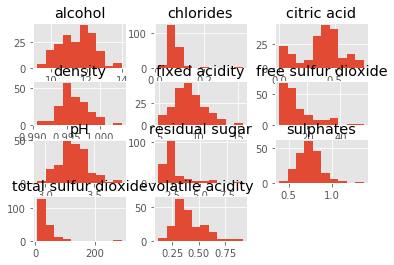

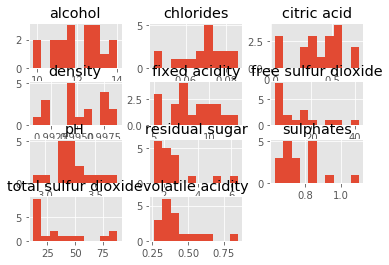

In [5]:
class_data.boxplot(['free sulfur dioxide','total sulfur dioxide'])
class_data.groupby('quality').hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000208F840C588>,
      dtype=object)

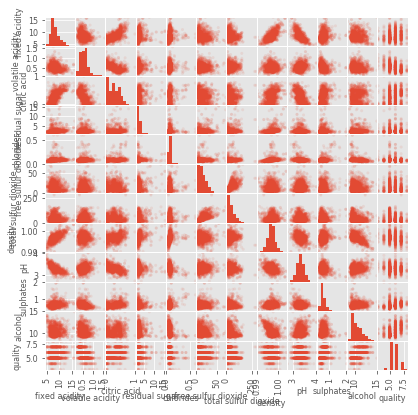

In [6]:
plt.rcParams['axes.labelsize'] = 8
scatter_matrix(class_data, alpha=0.1, figsize=(6.5,6.5))

In [7]:
pipeline = Pipeline([
    ('standardscaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=1))
])

In [31]:
# Instantiate unpruned Decision Tree
start = clock()
pipeline.fit(X_train, y_train)
stop = clock()
print('Time to fit unpruned tree: {:.4f}'.format(stop-start))

# Predict and score results
start = clock()
y_pred = pipeline.predict(X_test)
stop = clock()
print('Time to predict unpruned tree: {:.4f}'.format(stop-start))
acc_train = accuracy_score(y_train, pipeline.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
print('Unpruned decision tree training accuracy: {:.3f}'.format(acc_train))
print('Unpruned decision tree test accuracy: {:.3f}'.format(acc_test))

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))

Time to fit unpruned tree: 0.0137
Time to predict unpruned tree: 0.0016
Unpruned decision tree training accuracy: 1.000
Unpruned decision tree test accuracy: 0.575
[[ 0  1  0  0  0  0]
 [ 0  3  6  4  0  0]
 [ 2  5 90 35  8  0]
 [ 1  1 33 75 22  2]
 [ 0  1  3 11 15  0]
 [ 0  0  0  0  1  1]]


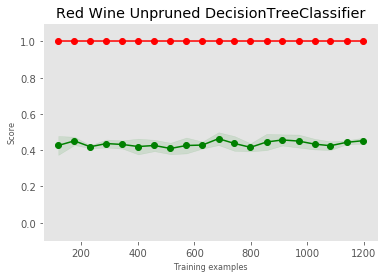

In [9]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, n_jobs=-1, 
                                                        cv=4, train_sizes=np.linspace(.1, 1.0, 20), verbose=0)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Red Wine Unpruned DecisionTreeClassifier")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
plt.ylim(-.1,1.1)
plt.show()

In [26]:
# Define the grid of hyperparameters 'params_dt'
params_dt = {
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': range(3,15,1),
    'clf__min_samples_split': np.arange(2,100,1),
    'clf__min_samples_leaf': np.arange(2,100,1),
    'clf__max_features': np.arange(0.6,1.01,0.1)
}

# Perform RandomizedSearchCV
randomized = RandomizedSearchCV(pipeline, param_distributions=params_dt, n_iter=40000, cv=4, scoring='accuracy',
                                refit=True, n_jobs = -1, verbose=1, random_state=123)

# Fit the estimator
start = clock()
randomized.fit(X_train, y_train)
stop = clock()
print('Time to hypertune: {:.3f}'.format(stop-start))

Fitting 4 folds for each of 40000 candidates, totalling 160000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 7680 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 13980 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 22080 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 31980 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 43680 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 57180 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 72480 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 89580 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 108480 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 129180 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 151680 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 160000 out of 160000 | elapsed:  5.0min finished


Time to hypertune: 304.917


In [27]:
# Extract best hyperparameters from 'grid'
print('Best hyperparameters:\n', randomized.best_params_)

# Extract best CV score from 'grid'
print('Best CV accuracy: {:.3f}'.format(randomized.best_score_))

# Extract best model from 'grid'
best_model = randomized.best_estimator_

# Evaluate test set accuracy
test_acc = best_model.score(X_test, y_test)

# Print test set accuracy
print('Test set accuracy of best model: {:.3f}'.format(test_acc))

# Print CV confusion matrix
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

# Mean fit and score time for best parameters
print('Mean fit time: {:.4f}'.format(randomized.cv_results_['mean_fit_time'][randomized.best_index_]))
print('Mean score time: {:.4f}'.format(randomized.cv_results_['mean_score_time'][randomized.best_index_]))

Best hyperparameters:
 {'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 0.7999999999999999, 'clf__max_depth': 13, 'clf__criterion': 'gini'}
Best CV accuracy: 0.557
Test set accuracy of best model: 0.597
[[ 0  0  0  1  0  0]
 [ 1  4  6  2  0  0]
 [ 3  4 87 41  5  0]
 [ 0  3 31 79 19  2]
 [ 0  0  3  7 20  0]
 [ 0  0  0  0  1  1]]
Mean fit time: 0.0150
Mean score time: 0.0012


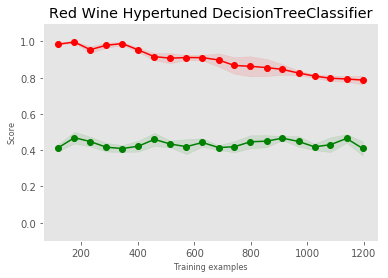

In [12]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, n_jobs=-1, 
                                                        cv=4, train_sizes=np.linspace(.1, 1.0, 20), verbose=0)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Red Wine Hypertuned DecisionTreeClassifier")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
plt.ylim(-.1,1.1)
plt.show()